In [1]:
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import copy, time, sys
import random
import pickle
from tqdm import tqdm 

import mlrfit as mf

/Users/parshakova.tanya/opt/anaconda3/envs/routing/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
np.random.seed(1001)
random.seed(1001)

In [3]:
rank = 30
mtype = "gics_hodlr"


with open('../../data_finance/crsp_gics_5k_C.npy', 'rb') as f:
       C = np.load(f)

with open("../outputs/hpart_uni_assetcov_allL.pickle", "rb") as f:
       hpart = pickle.load(f)

Z = mf.demean_clip(C)
A = Z @ Z.T / (Z.shape[1]-1)

# permute rows and cols to place partitions on the diagonal
perm_A = A[hpart['rows']['pi'], :][:, hpart['cols']['pi']]

m = n = A.shape[0]

symm = np.allclose(A, A.T) if m==n else False
if symm:
       print(f"MLR storage = {rank * m}")
else:
       print(f"MLR storage = {rank * (m + n)}")

mlr_storage = rank * (m + n)

MLR storage = 150000


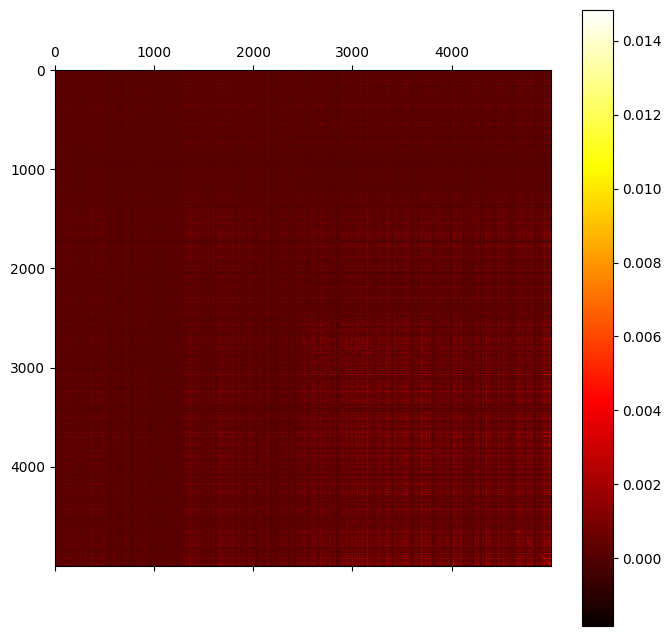

In [4]:
fig = plt.figure(figsize=(8, 8), dpi=100)
ax = fig.add_subplot(111)
cax = ax.matshow(perm_A, cmap='hot')
fig.colorbar(cax)
plt.show()

In [5]:
assert m == hpart['rows']['pi'].size and n == hpart['cols']['pi'].size
for level in range(len(hpart['rows']['lk'])):
    avg_rows = np.diff(np.array(hpart['rows']['lk'][level])).mean()
    avg_cols = np.diff(np.array(hpart['cols']['lk'][level])).mean()
    print(f"{level=}, {hpart['rows']['lk'][level].size-1}, {avg_rows=}, {avg_cols=}")

level=0, 1, avg_rows=5000.0, avg_cols=5000.0
level=1, 2, avg_rows=2500.0, avg_cols=2500.0
level=2, 4, avg_rows=1250.0, avg_cols=1250.0
level=3, 8, avg_rows=625.0, avg_cols=625.0
level=4, 16, avg_rows=312.5, avg_cols=312.5
level=5, 32, avg_rows=156.25, avg_cols=156.25
level=6, 64, avg_rows=78.125, avg_cols=78.125
level=7, 128, avg_rows=39.0625, avg_cols=39.0625
level=8, 256, avg_rows=19.53125, avg_cols=19.53125
level=9, 512, avg_rows=9.765625, avg_cols=9.765625
level=10, 1024, avg_rows=4.8828125, avg_cols=4.8828125
level=11, 2048, avg_rows=2.44140625, avg_cols=2.44140625
level=12, 4096, avg_rows=1.220703125, avg_cols=1.220703125
level=13, 5000, avg_rows=1.0, avg_cols=1.0


In [6]:
rel_tol = 0.0564375
tol = rel_tol * np.linalg.norm(A, ord='fro')
tol

0.10600873874960558

In [7]:
A_HODLR, A_HODLR_fillin, bl_sizes, count = mf.build_hodlr(hpart, m, n, A, tol)

100%|██████████| 14/14 [00:32<00:00,  2.32s/it]


In [8]:
np.histogram(A_HODLR_fillin.reshape(-1), bins=5)

(array([       0,        0, 25000000,        0,        0]),
 array([0.5, 0.7, 0.9, 1.1, 1.3, 1.5]))

In [9]:
hodlr_storage = mf.get_hodlr_storage(bl_sizes, count, m, n)

In [10]:
np.histogram(bl_sizes[:, 0])

(array([14992,     2,     0,     0,     2,     0,     0,     0,     0,
            2]),
 array([ 0.,  3.,  6.,  9., 12., 15., 18., 21., 24., 27., 30.]))

In [11]:
print(f"{rel_tol=},      err={mf.rel_diff(A_HODLR, den=A)},   {hodlr_storage=}")

# rel_tol=0.07001,   err=0.382551372546772,    hodlr_storage=77500
# rel_tol=0.0625,      err=0.378753475765454,   hodlr_storage=147500
# rel_tol=0.05875,      err=0.3757592071566259,   hodlr_storage=225000
# rel_tol=0.056874999999999995,      err=0.3559781191018474,   hodlr_storage=283752
# rel_tol=0.0564375,      err=0.3464302568492353,   hodlr_storage=301876
# rel_tol=0.056,      err=0.3463145117660767,   hodlr_storage=306876
# rel_tol=0.055,     err=0.3456386515521145,   hodlr_storage=341876
# rel_tol=0.04,      err=0.2866016310007384,   hodlr_storage=1238124
# rel_tol=0.01,      err=0.14748499561076153,  hodlr_storage=4901266
# rel_tol=0.007,     err=0.1252898686978118,   hodlr_storage=5762518

rel_tol=0.0564375,      err=0.3464302568492353,   hodlr_storage=301876


In [12]:
(0.056+0.056874999999999995)/2

0.0564375

In [19]:
72.5489/25.8

2.811972868217054

In [13]:
print(f"{hodlr_storage/2.=}")
print(f"  {mlr_storage/2.=}")
print(f"       {m * n =}")
mlr_storage * 1./ hodlr_storage

hodlr_storage/2.=150938.0
  mlr_storage/2.=150000.0
       m * n =25000000


0.99378552783262

In [14]:
# % LR             0.16178478761767168
# % LR+D           0.15379228686658158
# % RA uniform     0.15685427903055432
# % RA bottom      0.1537922860505496
# % RA top         0.15379228616060187

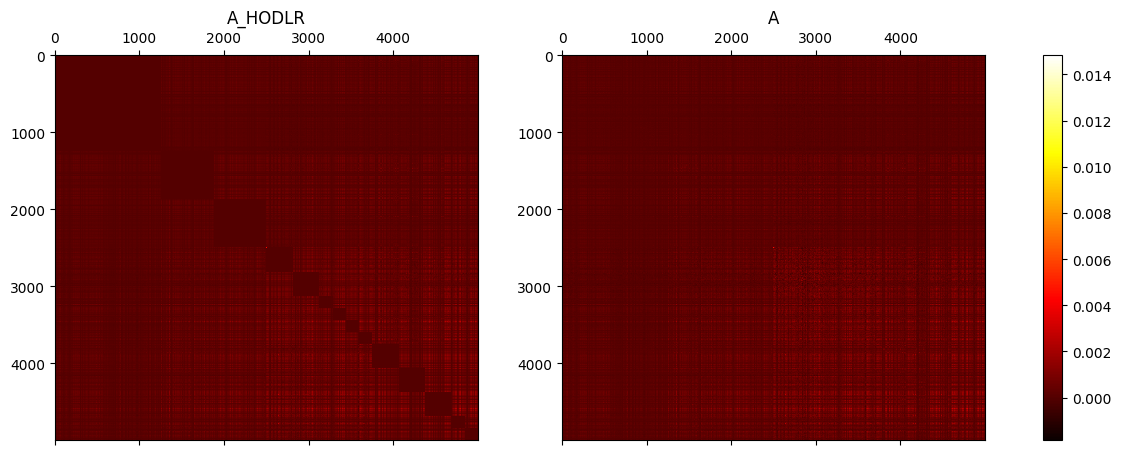

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5), dpi=100)
vmin = min(A.min(), A_HODLR.min())
vmax = max(A.max(), A_HODLR.max())

cax1 = axs[0].matshow(A_HODLR[hpart['rows']['pi'], :][:, hpart['cols']['pi']], cmap='hot', aspect='auto', vmin=vmin, vmax=vmax)
axs[0].set_title('A_HODLR')
perm_A = A[hpart['rows']['pi'], :][:, hpart['cols']['pi']]
cax2 = axs[1].matshow(perm_A, cmap='hot', aspect='auto', vmin=vmin, vmax=vmax)
axs[1].set_title('A')

fig.colorbar(cax1, ax=axs, orientation='vertical')
plt.show()

In [16]:
np.allclose(np.diag(A), np.diag(A_HODLR))

True